This notebook is used to reproduce the Figure 4 in the paper.

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from utils import random_task_generation,print_command
from pipette_scheduler import calculate_D, calculate_S_E, calculate_D_prime,calculate_X

In [8]:
labware_combinations = [[12,12],[24,24],[96,96],[384,384]]
source_path = Path('random_shuffling')
# make a directory as source_path if it does not exist
source_path.mkdir(parents=True, exist_ok=True)
for labware_combination in labware_combinations:
    (source_path / f'{labware_combination[0]}_{labware_combination[1]}').mkdir(parents=True, exist_ok=True)

In [9]:
stats = []
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'computed_run_time','name'])
np.random.seed(0)
for labware_combination in labware_combinations:
        print(f'labware_combination: {labware_combination}')
        count = 1
        for r in range (3):
            print('repeat:',r)
            # define the number of experiments based on the labware combinations
            if labware_combination[0] == 12 and labware_combination[1] == 12:
                num_candidates_list = [25,50,100]
            elif labware_combination[0] == 24 and labware_combination[1] == 24:
                num_candidates_list = [50,100,200,400]
            elif labware_combination[0] == 96 and labware_combination[1] == 96:
                num_candidates_list = [100,200,400,800,1600]
            elif labware_combination[0] == 384 and labware_combination[1] == 384:
                num_candidates_list = [200,400,800,1600,2400]
            for i in num_candidates_list:
                
                experiments = random_task_generation(labware_combination[0],labware_combination[1],i)
                #experiments[experiments>0] = 1
                jobs = np.argwhere(experiments)

                D_S = calculate_D(experiments.shape[0])
                D_D = calculate_D(experiments.shape[1])
                S, E, volumes = calculate_S_E(experiments)
                # calculate distance matrix
                D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, 1.5, 100, 1.5, 100)
                # calculate the cost of the non-optimized sequence
                tasks = np.array(range(jobs.shape[0]))
                # randomly shuffle the tasks
                np.random.shuffle(tasks)
                tasks_paddled = tasks.copy() +1
                # if tasks.shape[0] %8 != 0, pad with -1
                if tasks_paddled.shape[0] %8 != 0:
                    tasks_paddled = np.pad(tasks_paddled, (0, 8-tasks_paddled.shape[0]%8), 'constant', constant_values=-1)
                seuqnece = tasks_paddled.reshape(-1, 8)
                t = calculate_X(seuqnece)
                d = np.round(D_prime * 100)
                distance = np.trace(np.dot(t.T, d))/100
                distance = int(distance)
                print(f'distance: {distance}')
                # add the information to the dataframe
                file_name = f"{count}.csv"
                stats.append([labware_combination[0], labware_combination[1], i, r, distance, file_name])
                unoptimized_command_line = print_command(tasks,jobs,f'source{labware_combination[0]}', f'dest{labware_combination[1]}',volumes)
                np.savetxt(source_path / f'{labware_combination[0]}_{labware_combination[1]}'/file_name,
                           unoptimized_command_line,fmt='%s',delimiter=',')
                count += 1

labware_combination: [12, 12]
repeat: 0
distance: 91
distance: 192
distance: 383
repeat: 1
distance: 96
distance: 189
distance: 368
repeat: 2
distance: 97
distance: 195
distance: 377
labware_combination: [24, 24]
repeat: 0
distance: 185
distance: 388
distance: 775
distance: 1572
repeat: 1
distance: 189
distance: 398
distance: 770
distance: 1579
repeat: 2
distance: 188
distance: 397
distance: 781
distance: 1572
labware_combination: [96, 96]
repeat: 0
distance: 393
distance: 793
distance: 1584
distance: 3197
distance: 6332
repeat: 1
distance: 403
distance: 801
distance: 1569
distance: 3206
distance: 6360
repeat: 2
distance: 390
distance: 815
distance: 1580
distance: 3151
distance: 6360
labware_combination: [384, 384]
repeat: 0
distance: 792
distance: 1590
distance: 3182
distance: 6399
distance: 9571
repeat: 1
distance: 786
distance: 1607
distance: 3204
distance: 6398
distance: 9575
repeat: 2
distance: 795
distance: 1601
distance: 3215
distance: 6436
distance: 9610


In [ ]:
# print the statistics
stat_df = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'computed_run_time','name'])
stat_df.to_csv(source_path / 'random_shuffling_summary.csv', index=False)

In [12]:
# read the simulated vs computed data
df = pd.read_csv(source_path / 'simulated_vs_computed.csv',dtype={'Task': str})
df['Task'] = df['Task'].replace({"12 to 12": "12-well plate -> 12-well plate","24 to 24": "24-well plate -> 24-well plate", "96 to 96": "96-well plate -> 96-well plate", "384 to 384": "384-well plate -> 384-well plate"})
# transfer Task to color
tasks = df['Task'].unique()
# create a color map
color_map = {"12-well plate -> 12-well plate": "red", "24-well plate -> 24-well plate": "blue", "96-well plate -> 96-well plate": "green", "384-well plate -> 384-well plate": "orange"}
# add a new column to the dataframe
df['Color'] = df['Task'].map(color_map)

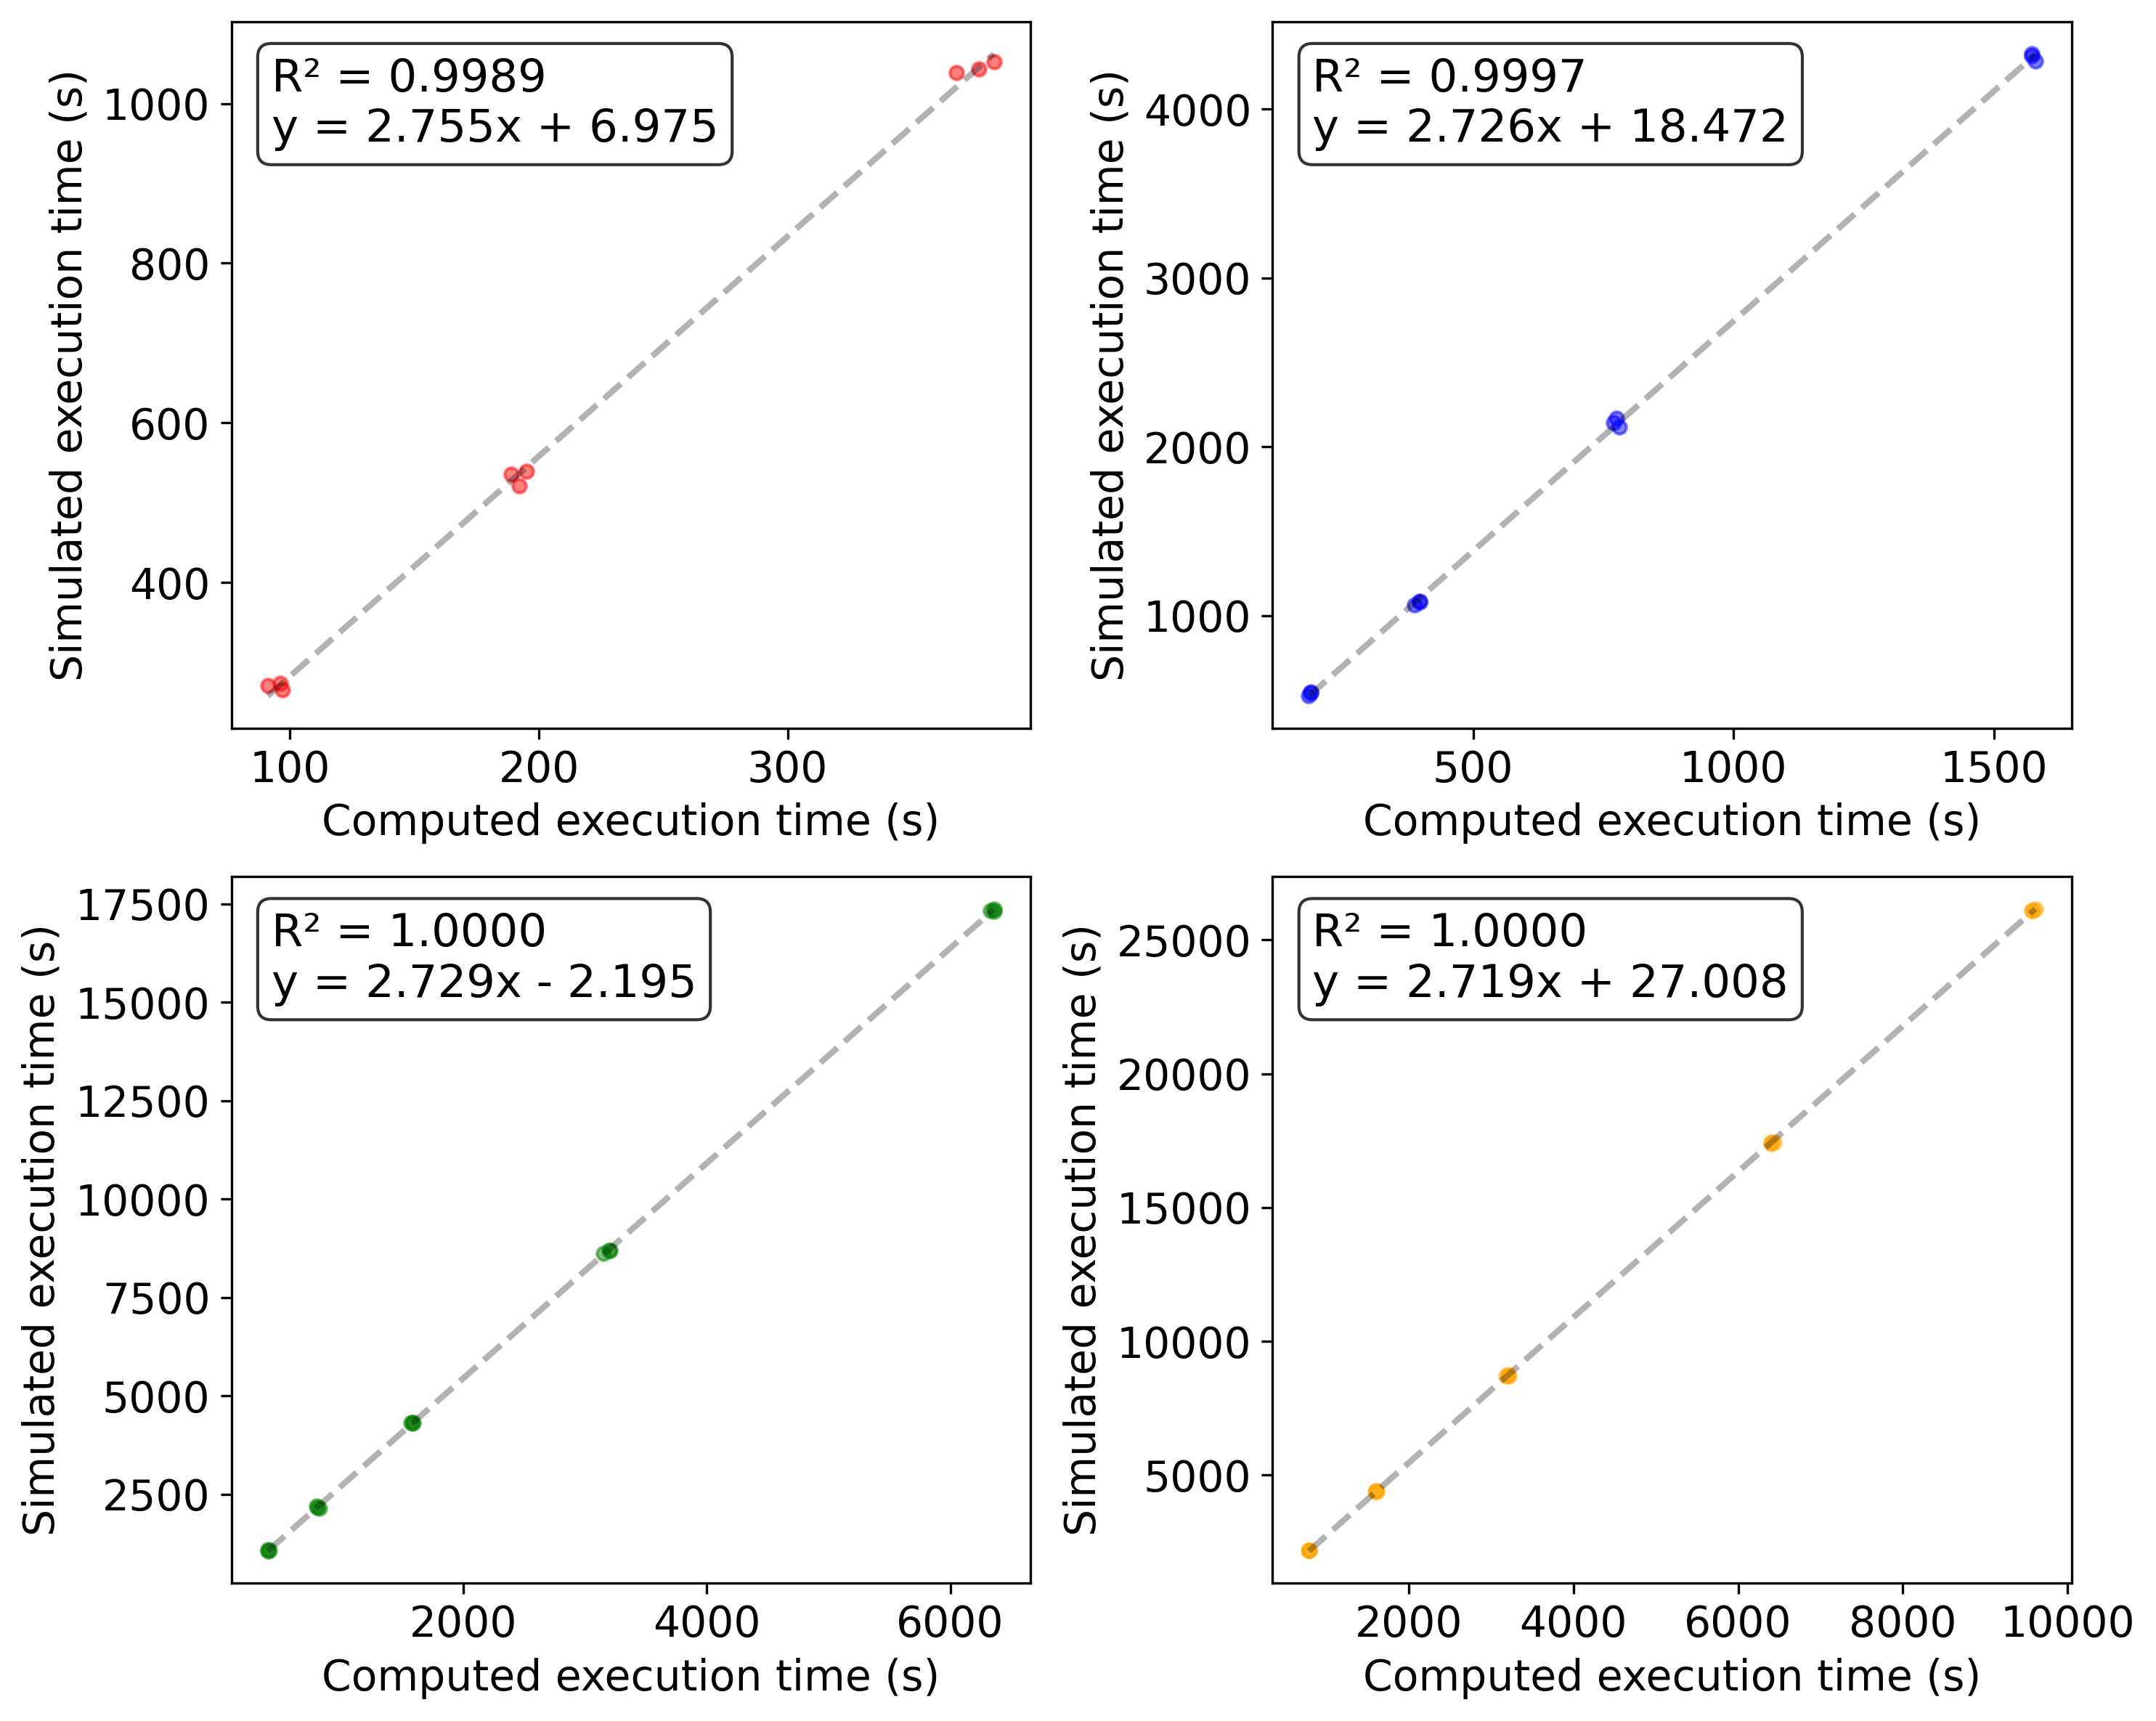

In [ ]:
# Create 4 subplots for each task type with trend lines and equations
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
axes = axes.flatten()

tasks = df['Task'].unique()

for i, task in enumerate(tasks):
    ax = axes[i]
    
    # Filter data for current task
    task_data = df[df['Task'] == task]
    
    # Scatter plot
    ax.scatter(task_data['Computed'], task_data['Simulated'], 
               c=color_map[task], alpha=0.5, s=20)
    
    # Calculate and plot trend line using linear regression (no log10)
    if len(task_data) > 1:  # Need at least 2 points for trend line
        z = np.polyfit(task_data['Computed'], task_data['Simulated'], 1)
        p = np.poly1d(z)
        slope, intercept = z[0], z[1]
        
        # Create smooth line for trend directly from the model
        x_min, x_max = task_data['Computed'].min(), task_data['Computed'].max()
        x_trend = np.linspace(x_min, x_max, 100)
        y_trend = p(x_trend)
        
        ax.plot(x_trend, y_trend, color='black', linewidth=2, linestyle='--', alpha=0.3)
        
        # Calculate R² using linear correlation (without log transformation)
        correlation_matrix = np.corrcoef(task_data['Computed'], task_data['Simulated'])
        r_squared = correlation_matrix[0,1]**2
        
        # Format equation in linear scale: y = slope*x + intercept
        if intercept >= 0:
            equation = f'y = {slope:.3f}x + {intercept:.3f}'
        else:
            equation = f'y = {slope:.3f}x - {abs(intercept):.3f}'
            
        ax.text(0.05, 0.95, f'R² = {r_squared:.4f}\n{equation}', 
                transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top', fontsize=15)

    # Set labels and title
    ax.set_xlabel('Computed execution time (s)', fontsize=14)
    ax.set_ylabel('Simulated execution time (s)', fontsize=14)    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()